In [1]:
import pandas as pd
import numpy as np
from sksurv.nonparametric import kaplan_meier_estimator as kmf
import matplotlib.pyplot as plt
from lifelines.statistics import logrank_test
import matplotlib.patches as mpatches

In [2]:
selected_cell = 'cDC1'

In [3]:
estimation = pd.read_csv('GSE14520.Immune.csv',index_col=0)
estimation.head()

,Other,Kupffer cells,TM1,SAMs,T cells,cDC2,cDC1,B cells,P-value,Correlation,RMSE
Mixture,,,,,,,,,,,
GSM362947,0.795587,0.000000,0.0,0.198073,0.0,0.006340,0.000000,0.000000,0,0.836349,0.627371
GSM362948,0.749988,0.000000,0.0,0.222772,0.0,0.000000,0.027240,0.000000,0,0.874710,0.602075
GSM362949,0.841705,0.000000,0.0,0.146727,0.0,0.009444,0.000000,0.002123,0,0.894655,0.568862
GSM362950,0.741674,0.000000,0.0,0.219812,0.0,0.000000,0.038017,0.000497,0,0.890577,0.590849
GSM362951,0.822098,0.018743,0.0,0.147846,0.0,0.000000,0.009941,0.001371,0,0.812186,0.646432


In [4]:
survival_data = pd.read_csv('GSE14520.Survival.csv',index_col=0)
survival_data.head()

,OS_E,OS,DFS_E,DFS
GSM,,,,
GSM363205,0,58.0,0,58.0
GSM363115,0,66.6,0,66.6
GSM362970,0,67.3,0,67.3
GSM363354,1,10.4,1,10.4
GSM363039,0,52.8,0,52.8


In [5]:
dfs_data = survival_data.filter(['DFS_E', 'DFS'])
dfs_data = dfs_data.dropna(axis=0,how='any')
binary = {1:True,0:False}
dfs_data['DFS_E'] = [binary[event] for event in dfs_data['DFS_E']]
dfs_data['DFS_T'] = [time for time in dfs_data['DFS']]
dfs_data.head()

,DFS_E,DFS,DFS_T
GSM,,,
GSM363205,False,58.0,58.0
GSM363115,False,66.6,66.6
GSM362970,False,67.3,67.3
GSM363354,True,10.4,10.4
GSM363039,False,52.8,52.8


In [6]:
survival_test = estimation.merge(dfs_data,left_index=True,right_index=True,how='inner')
survival_test.head()

,Other,Kupffer cells,TM1,SAMs,T cells,cDC2,cDC1,B cells,P-value,Correlation,RMSE,DFS_E,DFS,DFS_T
GSM362947,0.795587,0.0,0.0,0.198073,0.0,0.006340,0.000000,0.000000,0,0.836349,0.627371,True,50.0,50.0
GSM362948,0.749988,0.0,0.0,0.222772,0.0,0.000000,0.027240,0.000000,0,0.874710,0.602075,True,8.8,8.8
GSM362949,0.841705,0.0,0.0,0.146727,0.0,0.009444,0.000000,0.002123,0,0.894655,0.568862,True,18.2,18.2
GSM362950,0.741674,0.0,0.0,0.219812,0.0,0.000000,0.038017,0.000497,0,0.890577,0.590849,True,30.1,30.1
GSM362952,0.839561,0.0,0.0,0.143079,0.0,0.014693,0.002667,0.000000,0,0.787030,0.664757,False,54.3,54.3


In [7]:
survival_reorder = survival_test.sort_values(selected_cell,axis=0,ascending=False)
survival_reorder.head()

,Other,Kupffer cells,TM1,SAMs,T cells,cDC2,cDC1,B cells,P-value,Correlation,RMSE,DFS_E,DFS,DFS_T
GSM363217,0.733401,0.002021,0.000024,0.144239,0.000000,0.032576,0.087581,0.000158,0,0.028397,1.105233,False,54.5,54.5
GSM363271,0.632843,0.000000,0.000000,0.285892,0.000132,0.000000,0.080613,0.000520,0,0.815902,0.663068,False,28.7,28.7
GSM363222,0.766884,0.000000,0.000000,0.163601,0.000000,0.003949,0.065566,0.000000,0,0.763594,0.693359,True,49.1,49.1
GSM363420,0.680367,0.004400,0.000000,0.248935,0.000000,0.000000,0.055803,0.010495,0,0.822612,0.655651,True,0.2,0.2
GSM363388,0.533682,0.048923,0.033371,0.252089,0.010472,0.000000,0.051457,0.070005,0,0.500763,0.866705,True,11.6,11.6


In [8]:
running_length = len(survival_reorder)

logrank_tests = []
cut_points = []

for i in range(running_length):
    cut_point = int(i+1)
    E = list(survival_reorder['DFS_E'])
    mid_point = int(len(E)/2)
    E_high = E[:cut_point]
    E_low = E[cut_point:]
    S = list(survival_reorder['DFS_T'])
    S_high = S[:cut_point]
    S_low = S[cut_point:]
    results = logrank_test(S_high,S_low,E_high,E_low)
    p = results.p_value
    cut_points.append(cut_point)
    logrank_tests.append(p)

optimization = pd.DataFrame(logrank_tests,index=cut_points,columns=['Log Rank Test'])

In [9]:
optimization = optimization.dropna()
optimization = optimization.sort_values('Log Rank Test')
optimization = int(optimization.iloc[0].name)
#optimization = int(len(E)/2)

In [10]:
dfs_cut_level = survival_reorder[selected_cell][optimization]
dfs_cut_level

0.0155893568423036

In [11]:
E = list(survival_reorder['DFS_E'])
cut_point = optimization
E_high = E[:cut_point]
E_low = E[cut_point:]
S = list(survival_reorder['DFS_T'])
S_high = S[:cut_point]
S_low = S[cut_point:]
results = logrank_test(S_high,S_low,E_high,E_low)
p = results.p_value
p = round(p,5)
p

0.22341

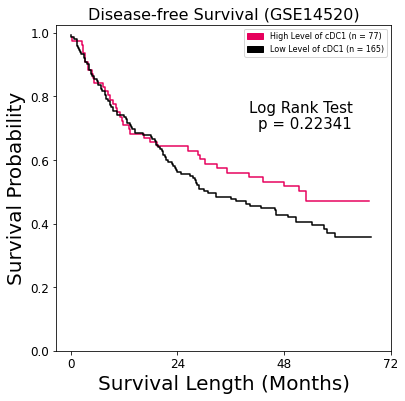

In [12]:
plt.figure(figsize=(6,6))
t,s = kmf(E_high, S_high)
plt.step(t,s,c='#e6005c')
t,s = kmf(E_low, S_low)
plt.step(t,s,c='k')
plt.xticks(np.arange(0,73,24),fontsize=12)
plt.yticks(np.arange(0,1.1,0.2),fontsize=12)
plt.xlabel('Survival Length (Months)', fontsize=20)
plt.ylabel('Survival Probability',fontsize=20)
high_patch = mpatches.Patch(color='#e6005c',label='High Level of cDC1 (n = %s)'%len(E_high))
low_patch = mpatches.Patch(color='k',label='Low Level of cDC1 (n = %s)'%len(E_low))
plt.text(40,0.75, 'Log Rank Test',fontsize=15)
plt.text(42,0.7, 'p = %s'%p,fontsize=15)
plt.legend(handles=[high_patch,low_patch],fontsize=8)
plt.title('Disease-free Survival (GSE14520)',fontsize=16)
plt.savefig('GSE14520.%s.DFS.pdf'%selected_cell,format='pdf')

In [13]:
os_data = survival_data.filter(['OS_E', 'OS'])
os_data = os_data.dropna(axis=0,how='any')
binary = {1:True,0:False}
os_data['OS_E'] = [binary[event] for event in os_data['OS_E']]
os_data['OS_T'] = [time for time in os_data['OS']]
os_data.head()

,OS_E,OS,OS_T
GSM,,,
GSM363205,False,58.0,58.0
GSM363115,False,66.6,66.6
GSM362970,False,67.3,67.3
GSM363354,True,10.4,10.4
GSM363039,False,52.8,52.8


In [14]:
survival_test = estimation.merge(os_data,left_index=True,right_index=True,how='inner')
survival_test.head()

,Other,Kupffer cells,TM1,SAMs,T cells,cDC2,cDC1,B cells,P-value,Correlation,RMSE,OS_E,OS,OS_T
GSM362947,0.795587,0.0,0.0,0.198073,0.0,0.006340,0.000000,0.000000,0,0.836349,0.627371,True,59.2,59.2
GSM362948,0.749988,0.0,0.0,0.222772,0.0,0.000000,0.027240,0.000000,0,0.874710,0.602075,False,61.4,61.4
GSM362949,0.841705,0.0,0.0,0.146727,0.0,0.009444,0.000000,0.002123,0,0.894655,0.568862,True,18.2,18.2
GSM362950,0.741674,0.0,0.0,0.219812,0.0,0.000000,0.038017,0.000497,0,0.890577,0.590849,False,57.5,57.5
GSM362952,0.839561,0.0,0.0,0.143079,0.0,0.014693,0.002667,0.000000,0,0.787030,0.664757,False,54.3,54.3


In [15]:
survival_reorder = survival_test.sort_values(selected_cell,axis=0,ascending=False)
survival_reorder

,Other,Kupffer cells,TM1,SAMs,T cells,cDC2,cDC1,B cells,P-value,Correlation,RMSE,OS_E,OS,OS_T
GSM363217,0.733401,0.002021,0.000024,0.144239,0.000000,0.032576,0.087581,0.000158,0,0.028397,1.105233,False,54.5,54.5
GSM363271,0.632843,0.000000,0.000000,0.285892,0.000132,0.000000,0.080613,0.000520,0,0.815902,0.663068,False,28.7,28.7
GSM363222,0.766884,0.000000,0.000000,0.163601,0.000000,0.003949,0.065566,0.000000,0,0.763594,0.693359,False,48.4,48.4
GSM363420,0.680367,0.004400,0.000000,0.248935,0.000000,0.000000,0.055803,0.010495,0,0.822612,0.655651,True,7.3,7.3
GSM363388,0.533682,0.048923,0.033371,0.252089,0.010472,0.000000,0.051457,0.070005,0,0.500763,0.866705,False,57.3,57.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM363211,0.799261,0.000000,0.000000,0.195085,0.000000,0.005654,0.000000,0.000000,0,0.826864,0.634960,True,8.9,8.9
GSM363010,0.844581,0.000000,0.000640,0.154779,0.000000,0.000000,0.000000,0.000000,0,0.835701,0.621451,False,62.0,62.0
GSM363200,0.850232,0.000000,0.000000,0.143309,0.000000,0.006459,0.000000,0.000000,0,0.849733,0.608660,True,23.9,23.9
GSM363198,0.763011,0.000000,0.000000,0.236989,0.000000,0.000000,0.000000,0.000000,0,0.777687,0.677409,False,57.9,57.9


In [16]:
running_length = len(survival_reorder)

logrank_tests = []
cut_points = []

for i in range(running_length):
    cut_point = int(i+1)
    E = list(survival_reorder['OS_E'])
    mid_point = int(len(E)/2)
    E_high = E[:cut_point]
    E_low = E[cut_point:]
    S = list(survival_reorder['OS_T'])
    S_high = S[:cut_point]
    S_low = S[cut_point:]
    results = logrank_test(S_high,S_low,E_high,E_low)
    p = results.p_value
    cut_points.append(cut_point)
    logrank_tests.append(p)

optimization = pd.DataFrame(logrank_tests,index=cut_points,columns=['Log Rank Test'])

In [17]:
optimization = optimization.dropna()
optimization = optimization.sort_values('Log Rank Test')
optimization = int(optimization.iloc[0].name)
#optimization = int(len(E)/2)

In [18]:
os_cut_level = survival_reorder[selected_cell][optimization]
os_cut_level

0.0244800314079288

In [19]:
E = list(survival_reorder['OS_E'])
cut_point = optimization
E_high = E[:cut_point]
E_low = E[cut_point:]
S = list(survival_reorder['OS_T'])
S_high = S[:cut_point]
S_low = S[cut_point:]
results = logrank_test(S_high,S_low,E_high,E_low)
p = results.p_value
p = round(p,5)
p

0.0647

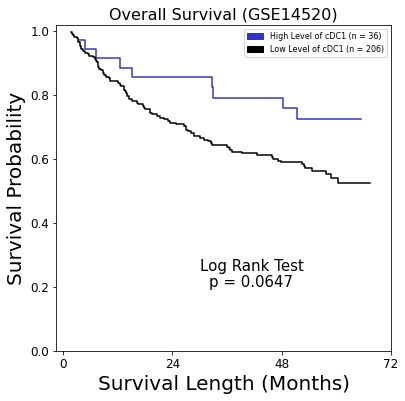

In [20]:
plt.figure(figsize=(6,6))
t,s = kmf(E_high, S_high)
plt.step(t,s,c='#3333cc')
t,s = kmf(E_low, S_low)
plt.step(t,s,c='k')
plt.xticks(np.arange(0,73,24),fontsize=12)
plt.yticks(np.arange(0,1.1,0.2),fontsize=12)
plt.xlabel('Survival Length (Months)', fontsize=20)
plt.ylabel('Survival Probability',fontsize=20)
high_patch = mpatches.Patch(color='#3333cc',label='High Level of cDC1 (n = %s)'%len(E_high))
low_patch = mpatches.Patch(color='k',label='Low Level of cDC1 (n = %s)'%len(E_low))
plt.text(30,0.25, 'Log Rank Test',fontsize=15)
plt.text(32,0.2, 'p = %s'%p,fontsize=15)
plt.legend(handles=[high_patch,low_patch],fontsize=8)
plt.title('Overall Survival (GSE14520)',fontsize=16)
plt.savefig('GSE14520.%s.OS.pdf'%selected_cell,format='pdf')

In [21]:
estimation = estimation.sort_values(selected_cell,ascending=False)
x = []
y = []
for key,value in enumerate(estimation[selected_cell]):
    x.append(key)
    y.append(value)

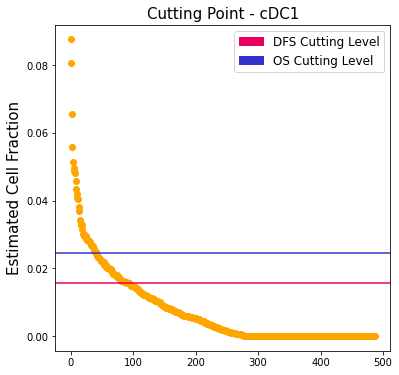

In [22]:
plt.figure(figsize=(6,6))
plt.scatter(x,y,color='orange')
plt.axhline(y=os_cut_level, xmin=0, xmax=100,color='#3333cc')
plt.axhline(y=dfs_cut_level, xmin=0, xmax=100,color='#e6005c')
plt.ylabel('Estimated Cell Fraction',fontsize=15)
plt.title('Cutting Point - %s'%selected_cell,fontsize=15)
dfs_patch = mpatches.Patch(color='#e6005c',label='DFS Cutting Level')
os_patch = mpatches.Patch(color='#3333cc',label='OS Cutting Level')
plt.legend(handles=[dfs_patch,os_patch],fontsize=12)
plt.savefig('Cutting_Point.%s'%selected_cell,format='pdf')